In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import torch
import logging
import os
import graphviz
import seaborn as sns
import umap

import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [17]:
# Create simulated data 

def simulate_data(num_samples = 1000, num_metabolites = 50, num_batches = 5, lambda_base = 30000):
    
    data_np = np.random.poisson(lambda_base, (num_samples, num_metabolites))

    # introduce missingness in batches 
    batch_size = num_samples // num_batches
    for batch_idx in range(num_batches):
        affected_metabolites = np.random.choice(range(num_metabolites), size=num_metabolites // 10, replace=False)
    
        # Set the counts of the affected metabolites to zero in the current batch
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size if batch_idx < num_batches - 1 else num_samples
        data_np[start_idx:end_idx, affected_metabolites] = 0
    
    data = torch.tensor(data_np, dtype=torch.float32)
    
    return data


In [18]:
def model(data):
    num_latent = 20
    
    W_prior = dist.HalfNormal(torch.ones(num_samples, num_latent)).to_event(2)
    H_prior = dist.HalfNormal(torch.ones(num_latent, num_metabolites)).to_event(2)
    Beta_prior = dist.Normal(loc=torch.zeros(num_batches), 
                             scale=torch.ones(num_batches)).to_event(1)
    
    # Sample from the priors
    W = pyro.sample("W", W_prior)
    H = pyro.sample("H", H_prior)
    Beta = pyro.sample("Beta", Beta_prior)
    Beta_expanded = Beta[labels].unsqueeze(-1) 

    # The mean parameter for the Poisson distribution
    lambda_ = torch.exp((torch.matmul(W, H)) + (Beta_expanded))
    
    # Observed data likelihood
    with pyro.plate("data", data.shape[0], dim=-2):
        with pyro.plate("features", data.shape[1], dim=-1):
            pyro.sample("obs", dist.Poisson(lambda_), obs=data)
    


In [19]:
def guide(data):
    num_latent = 20

    # Variational parameters for W and H
    W_scale = pyro.param("W_scale", torch.ones((num_samples, num_latent)), constraint=dist.constraints.positive)
    H_scale = pyro.param("H_scale", torch.ones((num_latent, num_metabolites)), constraint=dist.constraints.positive)
    
    Beta_loc = pyro.param("Beta_loc", torch.ones(num_batches))
    Beta_scale = pyro.param("Beta_scale", torch.ones(num_batches), constraint=dist.constraints.positive)  

     # Variational distributions
    pyro.sample("W", dist.HalfNormal(W_scale).to_event(2))
    pyro.sample("H", dist.HalfNormal(H_scale).to_event(2))
    pyro.sample("Beta", dist.Normal(Beta_loc, Beta_scale).to_event(1))
    

In [27]:
def learn():
    
    # Setup the optimizer
    adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # Setup the inference algorithm
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    #pyro.render_model(model, model_args=(data,), filename="model.png")
    # The training loop
    num_iterations = 2000
    losses = []  # Store the losses here
    
    for j in range(num_iterations):
        # Calculate the loss and take a gradient step
        loss = svi.step(data)
        losses.append(loss)
        if j % 100 == 0:
            print(f"Iteration {j} : loss = {loss}")
            W_learned = pyro.param("W_scale")
            H_learned = pyro.param("H_scale")
            Beta_learned = pyro.param("Beta_loc")
            print(f"W_learned mean: {W_learned.mean()}, std: {W_learned.std()}")
            print(f"H_learned mean: {H_learned.mean()}, std: {H_learned.std()}")
            #print(f"Beta_learned mean: {Beta_learned.mean()}, std: {Beta_learned.std()}")

    # After training, you may want to retrieve the learned embeddings and Beta matrix
    W_learned = pyro.sample("W_inferred", dist.HalfNormal(pyro.param("W_scale").data).to_event(2))
    H_learned = pyro.sample("H_inferred", dist.HalfNormal(pyro.param("H_scale").data).to_event(2))
    Beta_learned = pyro.param("Beta_scale")
    
    plt.plot(losses)
    plt.title('SVI Loss During Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    return(W_learned, H_learned, Beta_learned)

In [6]:
#data = simulate_data()
#data

In [21]:
metadata_metabolomics = pd.read_csv("~/Desktop/reznik/metabolomics/metadata.csv", index_col = 0)
metadata_sub = metadata_metabolomics[metadata_metabolomics['Isotope_Label'].isna()]
metadata_batch = metadata_sub.iloc[:,-1:]
#batch_labels = metadata_batch.to_numpy()
batch_labels = np.asarray(metadata_batch.T)
num_batches = len(np.unique(batch_labels))

In [22]:
mutation_labels = np.asarray(metadata_sub.loc[:,"Mutation_Pos"])
unique_mutations, mutation_indices = np.unique(mutation_labels, return_inverse=True)

In [23]:
heteroplasmy_vals = np.asarray(metadata_sub.loc[:, "Heteroplasmy"])
np.place(heteroplasmy_vals, heteroplasmy_vals == "WT", 0)
np.place(heteroplasmy_vals, heteroplasmy_vals == "Buffer Blank", 0)
heteroplasmy_vals = heteroplasmy_vals.astype(float)
heteroplasmy_values = np.unique(heteroplasmy_vals) 
K = len(np.unique(mutation_labels))

In [24]:
data_np = pd.read_csv("~/Desktop/reznik/metabolomics/master_file_metabolomics.csv", index_col = 0)
percent_missing = data_np.isnull().mean() * 100
filtered_df = data_np.loc[:, percent_missing <= 50]
filtered_df = filtered_df.replace(np.nan, 0)
data = torch.tensor(filtered_df.values, dtype=torch.float32).round()
data

tensor([[26.,  0., 15.,  ..., 31., 28., 21.],
        [25.,  0., 14.,  ..., 31., 28., 20.],
        [26.,  0., 15.,  ..., 31., 28., 20.],
        ...,
        [ 0.,  0.,  0.,  ..., 30.,  0., 13.],
        [ 0.,  0.,  0.,  ..., 29.,  0., 13.],
        [ 0.,  0.,  0.,  ..., 30.,  0., 14.]])

In [25]:
num_samples = data.shape[0]
num_metabolites = data.shape[1]
labels = batch_labels - 1
l2_strength = 0.01

Iteration 0 : loss = 1.752166697638298e+16
W_learned mean: 0.9900495409965515, std: 2.980301019306353e-07
H_learned mean: 0.9900497794151306, std: 5.964726312868152e-08
Iteration 100 : loss = 657729389146.2798
W_learned mean: 0.8544186949729919, std: 0.05355425924062729
H_learned mean: 0.8671761751174927, std: 0.05236330255866051
Iteration 200 : loss = 9877383545611.734
W_learned mean: 0.8240360617637634, std: 0.06807630509138107
H_learned mean: 0.849237322807312, std: 0.06148402765393257
Iteration 300 : loss = 158855398392.50415
W_learned mean: 0.8059265613555908, std: 0.07611636072397232
H_learned mean: 0.8363788723945618, std: 0.06820504367351532
Iteration 400 : loss = 23179009210.96121
W_learned mean: 0.7939634323120117, std: 0.08056557178497314
H_learned mean: 0.8252934217453003, std: 0.07635802775621414
Iteration 500 : loss = 64684012887.70432
W_learned mean: 0.782001793384552, std: 0.08485445380210876
H_learned mean: 0.8193596601486206, std: 0.07855502516031265
Iteration 600 : l

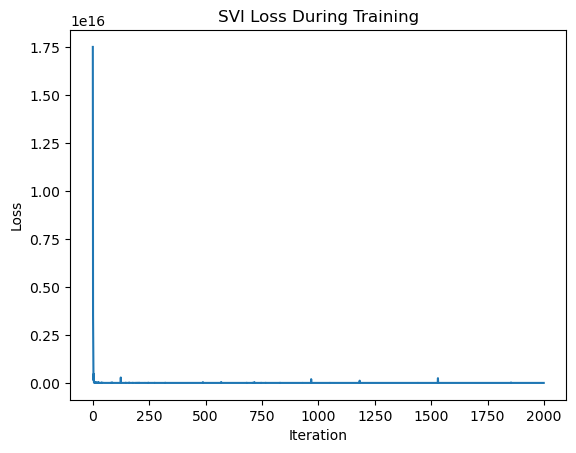

In [28]:
pyro.clear_param_store()
W_learned, H_learned, Beta_learned = learn()

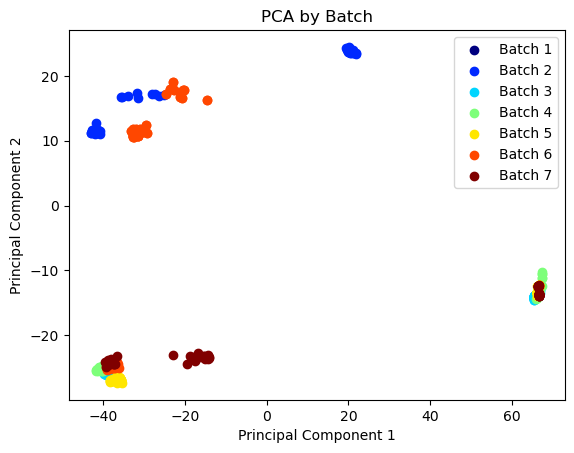

In [13]:

# Create a batch label for each sample
num_samples = data.shape[0]  # Number of samples in the simulated data
num_batches = 7  # As defined in simulate_data
#batch_labels = np.repeat(range(num_batches), num_samples / num_batches)

# Apply PCA and reduce the data to 2 principal components for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data.numpy())

# Create a DataFrame with the principal components and the batch information
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf['Batch'] = batch_labels.T

# Plotting the PCA
fig, ax = plt.subplots()

# Generate a color map for the number of batches
colors = plt.cm.jet(np.linspace(0, 1, num_batches))

# Color by batch
for batch, color in zip(range(num_batches), colors):
    idx = principalDf['Batch'] == batch
    ax.scatter(principalDf.loc[idx, 'PC1'], principalDf.loc[idx, 'PC2'], label=f'Batch {batch+1}', color=color)

plt.title('PCA by Batch')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

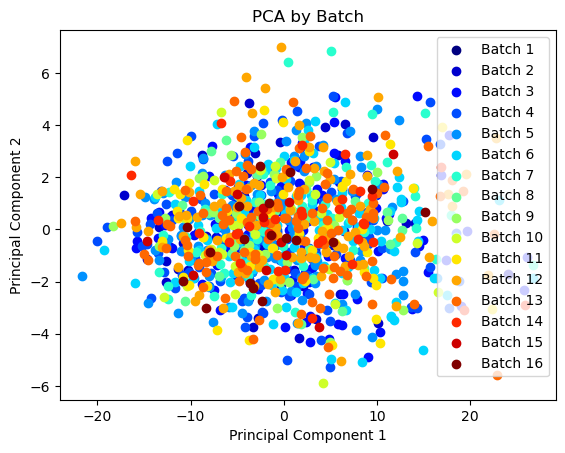

In [29]:
new_data = (torch.matmul(W_learned,H_learned)) 

# Create a batch label for each sample
num_samples = data.shape[0]  # Number of samples in the simulated data
num_batches = 16  # As defined in simulate_data
#batch_labels = np.repeat(range(num_batches), num_samples / num_batches)

# Apply PCA and reduce the data to 2 principal components for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(new_data.detach().numpy())

# Create a DataFrame with the principal components and the batch information
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf['Batch'] = batch_labels.T

# Plotting the PCA
fig, ax = plt.subplots()

# Generate a color map for the number of batches
colors = plt.cm.jet(np.linspace(0, 1, num_batches))

# Color by batch
for batch, color in zip(range(num_batches), colors):
    idx = principalDf['Batch'] == batch
    ax.scatter(principalDf.loc[idx, 'PC1'], principalDf.loc[idx, 'PC2'], label=f'Batch {batch+1}', color=color)

plt.title('PCA by Batch')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [15]:
new_data = (torch.matmul(W_learned,H_learned)) 

# Create a batch label for each sample
num_samples = data.shape[0]  # Number of samples in the simulated data
num_batches = len(np.unique(mutation_labels))  # As defined in simulate_data
#batch_labels = np.repeat(range(num_batches), num_samples / num_batches)

# Apply PCA and reduce the data to 2 principal components for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(new_data.detach().numpy())

# Create a DataFrame with the principal components and the batch information
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf['Batch'] = categorical_array.T

# Plotting the PCA
fig, ax = plt.subplots()

# Generate a color map for the number of batches
colors = plt.cm.jet(np.linspace(0, 1, num_batches))

# Color by batch
for batch, color in zip(range(num_batches), colors):
    idx = principalDf['Batch'] == batch
    ax.scatter(principalDf.loc[idx, 'PC1'], principalDf.loc[idx, 'PC2'], label=f'Mutation {batch+1}', color=color)

plt.title('PCA by Mutation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

NameError: name 'categorical_array' is not defined

In [ ]:
new_data = (torch.matmul(W_learned,H_learned)) 
new_data

In [35]:
mutation_labels = np.nan_to_num(mutation_labels)

In [36]:
unique_values = np.unique(mutation_labels)

value_to_int = {value: idx for idx, value in enumerate(unique_values)}

categorical_array = np.array([value_to_int[value] for value in mutation_labels])
categorical_array

array([0, 3, 0, ..., 0, 0, 0])

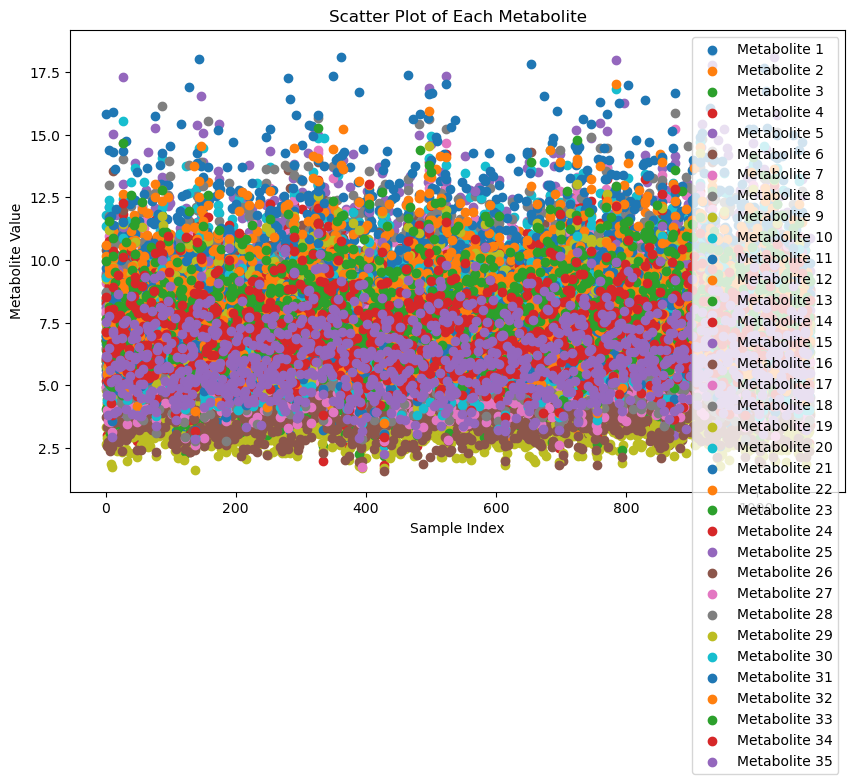

In [44]:

plt.figure(figsize=(10, 6))

for i in range(num_metabolites):
    plt.scatter(range(num_samples), new_data[:, i], label=f'Metabolite {i+1}')

plt.xlabel('Sample Index')
plt.ylabel('Metabolite Value')
plt.title('Scatter Plot of Each Metabolite')
plt.legend()

# Show the plot
plt.show()

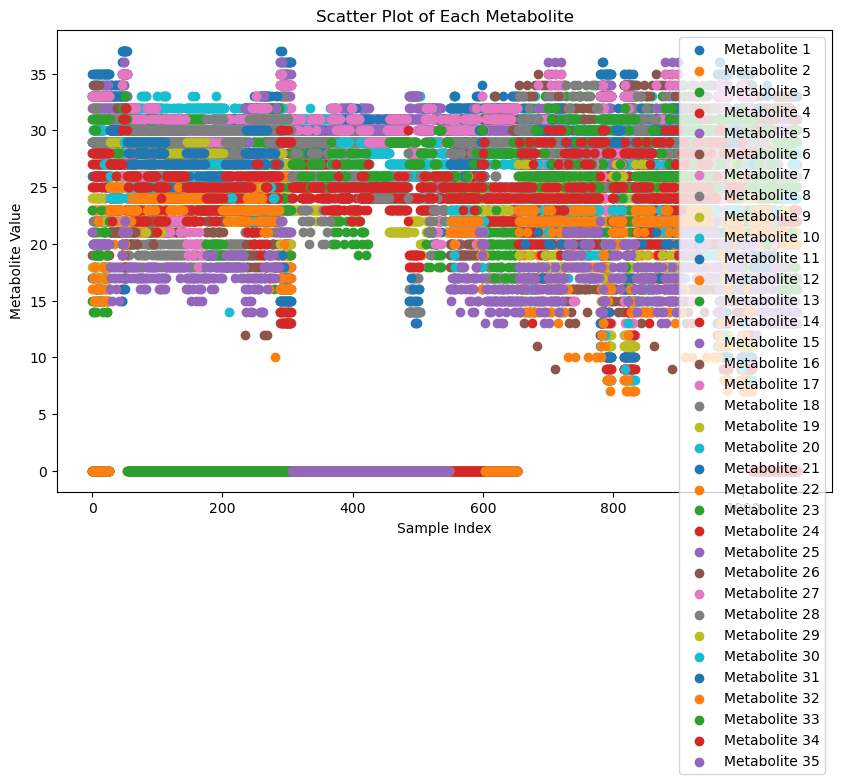

In [45]:

plt.figure(figsize=(10, 6))

# Plot each metabolite
for i in range(num_metabolites):
    plt.scatter(range(num_samples), data[:, i], label=f'Metabolite {i+1}')

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('Metabolite Value')
plt.title('Scatter Plot of Each Metabolite')
plt.legend()

# Show the plot
plt.show()

In [38]:
mean = torch.mean(data, dim=1)
std_dev = torch.std(data, dim=1)
rsd = (std_dev / mean) * 100
sorted_rsd, _ = torch.sort(rsd)
cumulative = torch.linspace(0, 1, steps=len(sorted_rsd))

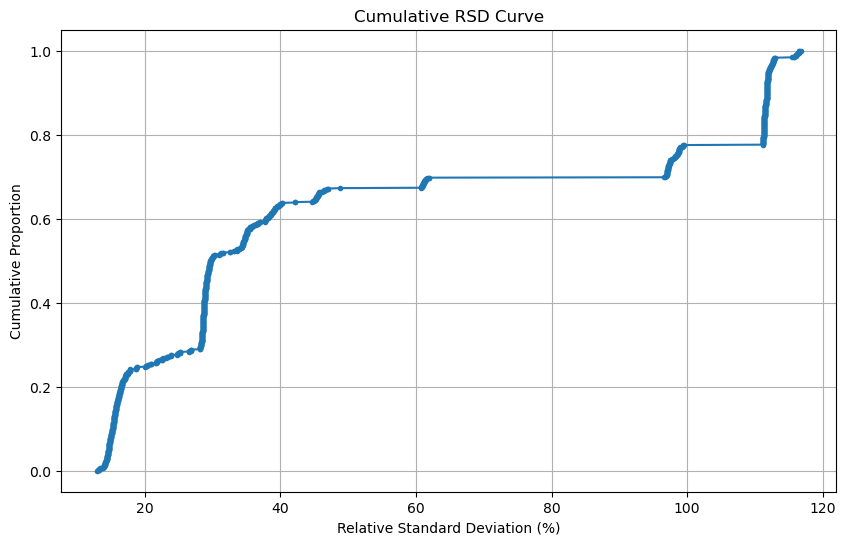

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_rsd.numpy(), cumulative.numpy(), marker='.', linestyle='-')
plt.xlabel('Relative Standard Deviation (%)')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative RSD Curve')
plt.grid(True)
plt.show()

In [40]:
mean = torch.mean(new_data, dim=1)
std_dev = torch.std(new_data, dim=1)
rsd = (std_dev / mean) * 100
sorted_rsd, _ = torch.sort(rsd)
cumulative = torch.linspace(0, 1, steps=len(sorted_rsd))

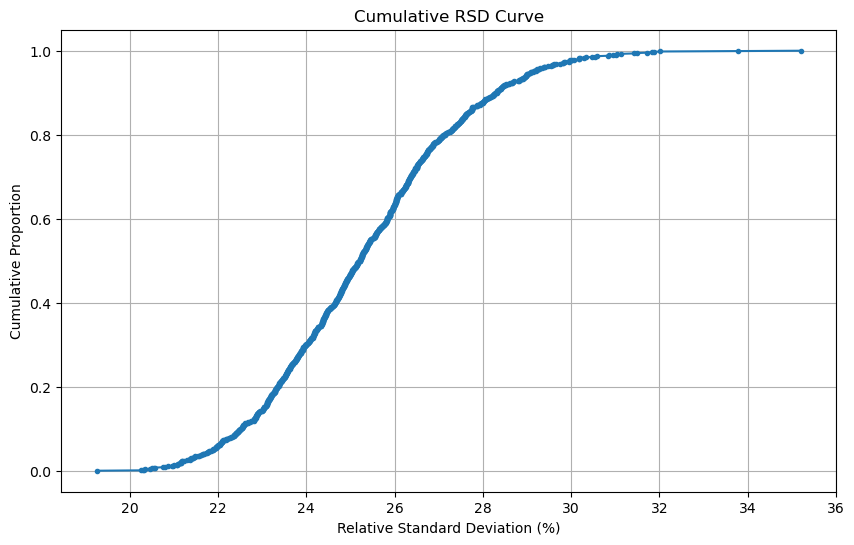

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_rsd.numpy(), cumulative.numpy(), marker='.', linestyle='-')
plt.xlabel('Relative Standard Deviation (%)')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative RSD Curve')
plt.grid(True)
plt.show()

/Users/boscens/miniconda3/envs/myenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


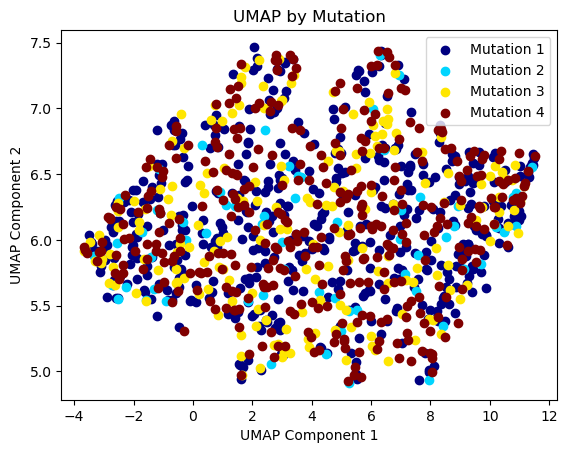

In [42]:
# Compute UMAP components
umap_model = UMAP(n_components=2, random_state=42)  # You can adjust parameters as needed
umap_components = umap_model.fit_transform(new_data.detach().numpy())

# Create a DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
umap_df['Batch'] = categorical_array.T  # Assuming categorical_array represents batch information

# Plotting the UMAP
fig, ax = plt.subplots()

# Generate a color map for the number of batches
num_batches = len(np.unique(mutation_labels))
colors = plt.cm.jet(np.linspace(0, 1, num_batches))

# Color by batch
for batch, color in zip(range(num_batches), colors):
    idx = umap_df['Batch'] == batch
    ax.scatter(umap_df.loc[idx, 'UMAP1'], umap_df.loc[idx, 'UMAP2'], label=f'Mutation {batch+1}', color=color)

plt.title('UMAP by Mutation')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

In [32]:
from umap.umap_ import UMAP